In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
%matplotlib inline
import IV_model

In [2]:
from IPython.display import HTML

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


In [4]:
# environment parameters
R=8.314
F=96485.0

oT =700+273.15      #Temperature oxidant (K)
fT =700+273.15      #Temperature fuel (K)
Tk=(oT+fT)/2.0
Tc=Tk-273.0

pO2air=0.3          #Air side partial pressure O2 (atm)
pN2air =0.7         #Air side partial pressure N2 (atm)
# pH2 = 0.4375        #Fuel side partial pressure H2 (atm)
# pH2O =0.3125        #Fuel side partial pressure H2O (atm)
# pCO=0.0625          #Fuel side partial pressure CO (atm)
# pCO2=0.0625         #Fuel side partial pressure CO2 (atm)
# pCH4=0.125          #Fuel side partial pressure CH4 (atm)
# pN2=0.0             #Fuel side partial pressure N2 (atm)
pH2 = 0.97        #Fuel side partial pressure H2 (atm)
pH2O =0.03        #Fuel side partial pressure H2O (atm)
pCO=0.0         #Fuel side partial pressure CO (atm)
pCO2=0.0         #Fuel side partial pressure CO2 (atm)
pCH4=0.0          #Fuel side partial pressure CH4 (atm)
pN2=0.0             #Fuel side partial pressure N2 (atm)
pSys=1.0            #System pressure (atm)  

# fuel cell property parameters
de_a = 0.61           #diameter of electrically conducting particles for anode 0.2-0.8
ne_a = 0.2              #number fraction of electrically conducting particles for anode 0.2-0.6
alpha_a = 0.475/0.61      #the particle size ratio of ionic to electronic conducting particles for anode 0.5-2.0
de_c = de_a          #**   #for cathode
ne_c = ne_a           #**  #for cathode
alpha_c = alpha_a     #**  #for cathode
d0_am = 0.228 # pore diameter [microm]
d0_cm = d0_am

# adjustable parameters for B-V loss (starting with these for optimization)
BV_alpha = 0.43236 #0.43236/3 **
BV_prexp = 5639 #**
BV_Eact = 79616 #**

# IV_new_2: Scaled BV Parameters

In [5]:
# comparison between JHM-2017 experimental data and   
#initilize and optimize
param_guess = (1.68337658e-01,  5.63899996e+03,  7.96160000e+04, -4.40813228e-02, 2.19648164e-01,  2.00000000e-01,  2.79706800e-01)

# BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
# DsurfH2th1=0.1, DsurfH2th2=4.51e-5,
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Tlist = [650, 700, 750, 800, 850]
th_e = 10
param_fixed = [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys]

def objective_function_JM(param_guess, param_fixed):  
    
    [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys] = param_fixed

    filename = './ExperimentalData/JM2017/AllData_JM.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_model.IV_new_2(Toper[j]+273.15,Toper[j]+273.15,x[j],
                                                           pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                           param_guess[0], param_guess[1], param_guess[2],
                                                           param_guess[3], param_guess[4], 0.1, 4.51e-5,
                                                             True,param_guess[5],param_guess[6])
    #rmse = mean_squared_error(y_exp, y_model, squared=False)
    rmse = mean_squared_error(y_exp, y_model,squared=False)
    return rmse

obj_guess = objective_function_JM(param_guess, param_fixed)
bnds = ((None, None), (None, None), (None, None), (None, 0), (0, None), (0.2, 2.0), (0.2, 2.0))
#bnds = ((0.2, 0.8), (0, None), (0, None), (None, 0), (0, None), (0.2, 2.0), (0.2, 2.0))
result = minimize(objective_function_JM, param_guess, args = (param_fixed), method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']
plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './ExperimentalData/JM2017/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=20)   #Current density, unit [A/cm2]
    Vlist = np.zeros(20)
    
    # plot pred data
    for j in range(20):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_model.IV_new_2(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                       result.x[0],result.x[1],result.x[2],
                                                       result.x[3], result.x[4], 0.1, 4.51e-5,
                                                       True,result.x[5],result.x[6])
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.xlim(-0.1, 1.1)
plt.ylim(0.4, 1.1)
# ymin, ymax = plt.ylim()
# plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

C:\Users\Mihyun Kim\Downloads\GitHub\NGFC-Lib\jupyter\Python_IV_Curve\2_IV_Model_Update\Match_Experimental_Data\IV_model.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  BV=(R*Tk/BV_alpha/F)*math.log((J/2.0/(i0))+math.sqrt((J/2.0/(i0))**2+1))
C:\Users\Mihyun Kim\Downloads\GitHub\NGFC-Lib\jupyter\Python_IV_Curve\2_IV_Model_Update\Match_Experimental_Data\IV_model.py:88: RuntimeWarning: invalid value encountered in double_scalars
  BV=(R*Tk/BV_alpha/F)*math.log((J/2.0/(i0))+math.sqrt((J/2.0/(i0))**2+1))


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [6]:
#comparison between Park-2020 experimental data (t8) and IV_new predicitons

#initilize and optimize
param_guess = (2.69263711e-01,  5.63900022e+03,  7.96160001e+04, -5.98828589e-02, 0.00000000e+00,  2.00000000e+00,  3.72783474e-01)
#bnds = ((0.0, 1.0), (0, None), (0, None), (None, 0), (0, None), (0.2, 2.0), (0.2, 2.0)) ## bounds changed
bnds = ((None, None), (None, None), (None, None), (None, 0), (0, None), (0.2, 2.0), (0.2, 2.0))
# BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
# DsurfH2th1=0.1, DsurfH2th2=4.51e-5,
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Tlist = [600, 700, 800]
th_e = 8
param_fixed = [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,th_e]

def objective_function_BP(param_guess, param_fixed):  
    filename = './ExperimentalData/BP2020/AllData_BP.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]
    [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,th_e] = param_fixed

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_model.IV_new_2(Toper[j]+273.15,Toper[j]+273.15,x[j],
                                                           pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                           param_guess[0],param_guess[1],param_guess[2],
                                                           param_guess[3], param_guess[4], 
                                                           0.1, 4.51e-5, True, param_guess[5], param_guess[6],  th_e)
    rmse = mean_squared_error(y_exp, y_model, squared=False)
    return rmse

obj_guess = objective_function_BP(param_guess, param_fixed)
result = minimize(objective_function_BP, param_guess, args = (param_fixed), method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']

plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './ExperimentalData/BP2020/t8/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=20)   #Current density, unit [A/cm2]
    Vlist = np.zeros(20)
    
    # plot pred data
    for j in range(20):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_model.IV_new_2(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys, 
                                                         result.x[0],result.x[1],result.x[2], 
                                                         result.x[3], result.x[4], 
                                                         0.1, 4.51e-5, True, result.x[5], result.x[6],  th_e)
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

C:\Users\Mihyun Kim\Downloads\GitHub\NGFC-Lib\jupyter\Python_IV_Curve\2_IV_Model_Update\Match_Experimental_Data\IV_model.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  BV=(R*Tk/BV_alpha/F)*math.log((J/2.0/(i0))+math.sqrt((J/2.0/(i0))**2+1))
C:\Users\Mihyun Kim\Downloads\GitHub\NGFC-Lib\jupyter\Python_IV_Curve\2_IV_Model_Update\Match_Experimental_Data\IV_model.py:88: RuntimeWarning: invalid value encountered in double_scalars
  BV=(R*Tk/BV_alpha/F)*math.log((J/2.0/(i0))+math.sqrt((J/2.0/(i0))**2+1))


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# IV_new_3: hyperbolic sine

     fun: 0.015169440541036796
     jac: array([ 2.14850064e-03,  7.08852895e-07, -6.25499524e-07,  1.33420096e-03,
       -4.93346830e-04,  5.13318100e-03,  8.53335951e-06])
 message: 'Optimization terminated successfully'
    nfev: 117
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([ 1.68334655e-01,  5.63899994e+03,  7.96160000e+04, -4.40787208e-02,
        2.19644090e-01,  2.00000000e-01,  2.79458248e-01])
6
9
12
13
14


Text(0.5, 1.0, 'EXP. VS. IV_new')

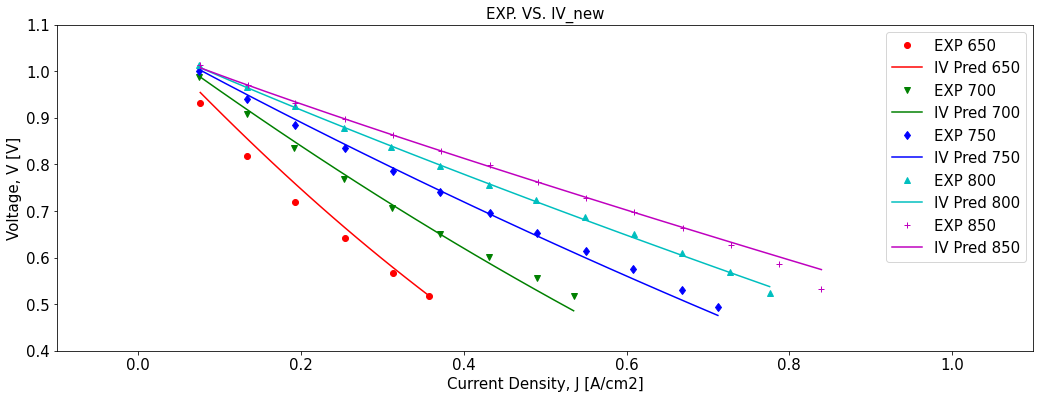

In [9]:
# comparison between JHM-2017 experimental data and IV_new predicitons

#initilize and optimize
param_guess = (1.68238059e-01,  5.63899994e+03,  7.96160000e+04, 0.0, 0.0, 0.28, 0.28)

# BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
# DsurfH2th1=0.1, DsurfH2th2=4.51e-5,
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Tlist = [650, 700, 750, 800, 850]
th_e = 10
param_fixed = [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys]

def objective_function_JM(param_guess, param_fixed):  
    
    [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys] = param_fixed

    filename = './ExperimentalData/JM2017/AllData_JM.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_model.IV_new_3(Toper[j]+273.15,Toper[j]+273.15,x[j],
                                                           pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                           param_guess[0], param_guess[1], param_guess[2],
                                                           param_guess[3], param_guess[4], 0.1, 4.51e-5,
                                                             True,param_guess[5],param_guess[6])
    rmse = mean_squared_error(y_exp, y_model, squared=False)
    return rmse

obj_guess = objective_function_JM(param_guess, param_fixed)
bnds = ((None, None), (None, None), (None, None), (None, 0), (0, None), (0.2, 2.0), (0.2, 2.0))
result = minimize(objective_function_JM, param_guess, args = (param_fixed), method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']
plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './ExperimentalData/JM2017/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=20)   #Current density, unit [A/cm2]
    Vlist = np.zeros(20)
    
    # plot pred data
    for j in range(20):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_model.IV_new_3(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                       result.x[0],result.x[1],result.x[2],
                                                       result.x[3], result.x[4], 0.1, 4.51e-5,
                                                       True,result.x[5],result.x[6])
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.xlim(-0.1, 1.1)
plt.ylim(0.4, 1.1)
# ymin, ymax = plt.ylim()
# plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

     fun: 0.019428362629372673
     jac: array([ 3.43002635e-03, -1.20536424e-06, -6.95697963e-07,  3.49426083e-03,
        4.05821188e-01, -1.19453436e-03, -3.33268661e-04])
 message: 'Optimization terminated successfully'
    nfev: 107
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([ 2.69218132e-01,  5.63900045e+03,  7.96160002e+04, -5.97469329e-02,
        0.00000000e+00,  2.00000000e+00,  3.62167047e-01])


Text(0.5, 1.0, 'EXP. VS. IV_new')

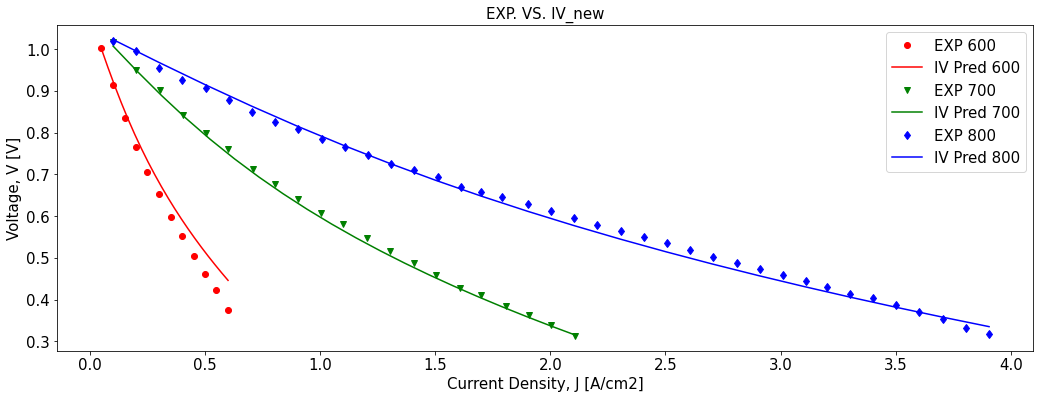

In [10]:
#comparison between Park-2020 experimental data (t8) and IV_new predicitons

#initilize and optimize
param_guess = (2.69225857e-01,  5.63900022e+03,  7.96160001e+04, 0.0, 0.0, 0.228, 0.228)
bnds = ((0.2, 0.7), (0, None), (0, None), (None, 0), (0, None), (0.2, 2.0), (0.2, 2.0)) ## bounds changed

# BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
# DsurfH2th1=0.1, DsurfH2th2=4.51e-5,
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Tlist = [600, 700, 800]
th_e = 8
param_fixed = [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,th_e]

def objective_function_BP(param_guess, param_fixed):  
    filename = './ExperimentalData/BP2020/AllData_BP.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]
    [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,th_e] = param_fixed

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_model.IV_new_3(Toper[j]+273.15,Toper[j]+273.15,x[j],
                                                           pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                           param_guess[0],param_guess[1],param_guess[2],
                                                           param_guess[3], param_guess[4], 
                                                           0.1, 4.51e-5, True, param_guess[5], param_guess[6],  th_e)
    rmse = mean_squared_error(y_exp, y_model, squared=False)
    return rmse

obj_guess = objective_function_BP(param_guess, param_fixed)
result = minimize(objective_function_BP, param_guess, args = (param_fixed), method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']

plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './ExperimentalData/BP2020/t8/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=20)   #Current density, unit [A/cm2]
    Vlist = np.zeros(20)
    
    # plot pred data
    for j in range(20):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_model.IV_new_3(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys, 
                                                         result.x[0],result.x[1],result.x[2], 
                                                         result.x[3], result.x[4], 
                                                         0.1, 4.51e-5, True, result.x[5], result.x[6],  th_e)
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)


changing the bounds for alpha helped alot. But, when trying to optimize, both the preexp and and bv_eact did not change to fit. 


## IV Model 3_5: Updated Hyperbolic Sine equation(Meng.et)

     fun: 0.023706680183943476
     jac: array([-6.31463982e-02, -1.68755651e-06, -5.13542909e-05,  3.80715029e-03,
       -2.17401469e-03,  3.87713290e-03, -7.26431608e-07])
 message: 'Optimization terminated successfully'
    nfev: 82
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([ 7.00000000e-01,  1.00000846e+00,  2.00000485e+02, -2.60802600e-02,
        5.32689266e-01,  2.00000000e-01,  2.79295936e-01])


Text(0.5, 1.0, 'EXP. VS. IV_new')

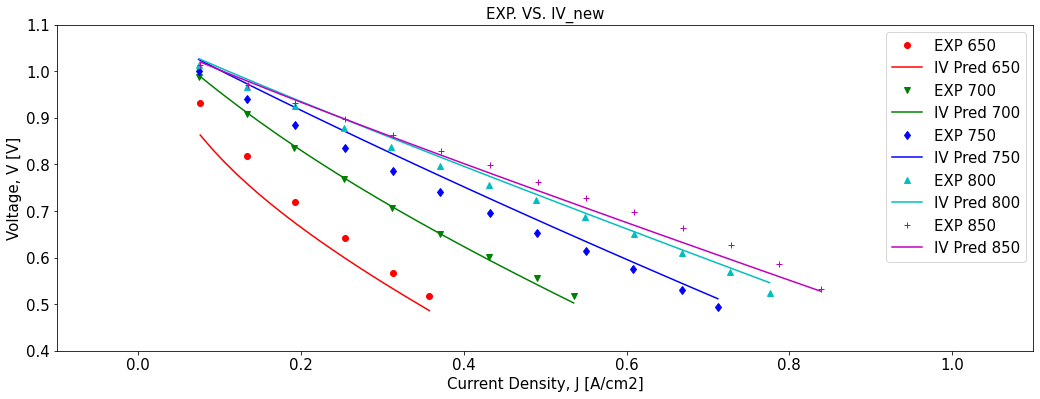

In [11]:
# comparison between JHM-2017 experimental data and IV_new predicitons

#initilize and optimize
param_guess = (0.5,1, 200, 0, 0, 0.28, 0.28)

# BV_alpha, Prex_A,Prex_C, V_loss=0.0, R_cont=0.0, 
# DsurfH2th1=0.1, DsurfH2th2=4.51e-5,
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Tlist = [650, 700, 750, 800, 850]
th_e = 10
param_fixed = [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys]

def objective_function_JM(param_guess, param_fixed):  
    
    [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys] = param_fixed

    filename = './ExperimentalData/JM2017/AllData_JM.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_model.IV_new_3_5(Toper[j]+273.15,Toper[j]+273.15,x[j],
                                                           pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                           param_guess[0],param_guess[1], param_guess[2],
                                                             param_guess[3], param_guess[4], 0.1, 4.51e-5,
                                                             True,param_guess[5],param_guess[6])
    rmse = mean_squared_error(y_exp, y_model, squared=False)
    return rmse

obj_guess = objective_function_JM(param_guess, param_fixed)
bnds = ((0.2, 0.7),( 0,None),(0,None), (None, 0), (0, None), (0.2, 2.0), (0.2, 2.0))
result = minimize(objective_function_JM, param_guess, args = (param_fixed), method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']
plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './ExperimentalData/JM2017/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=20)   #Current density, unit [A/cm2]
    Vlist = np.zeros(20)
    
    # plot pred data
    for j in range(20):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_model.IV_new_3_5(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                       result.x[0],result.x[1],result.x[2],
                                                       result.x[3], result.x[4], 0.1, 4.51e-5,
                                                       True,result.x[5],result.x[6])
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.xlim(-0.1, 1.1)
plt.ylim(0.4, 1.1)
# ymin, ymax = plt.ylim()
# plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

     fun: 0.04316015313609514
     jac: array([-1.58117679e-02,  1.77370384e-06,  6.40423968e-06, -1.65291131e-05,
        9.64896753e-05,  1.76193449e-02, -8.42828304e-05])
 message: 'Optimization terminated successfully'
    nfev: 84
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([ 7.00000000e-01,  1.99998952e+00,  9.99999977e+02, -7.52749823e-02,
        1.23543412e-01,  2.00000000e-01,  2.80520754e-01])


Text(0.5, 1.0, 'EXP. VS. IV_new')

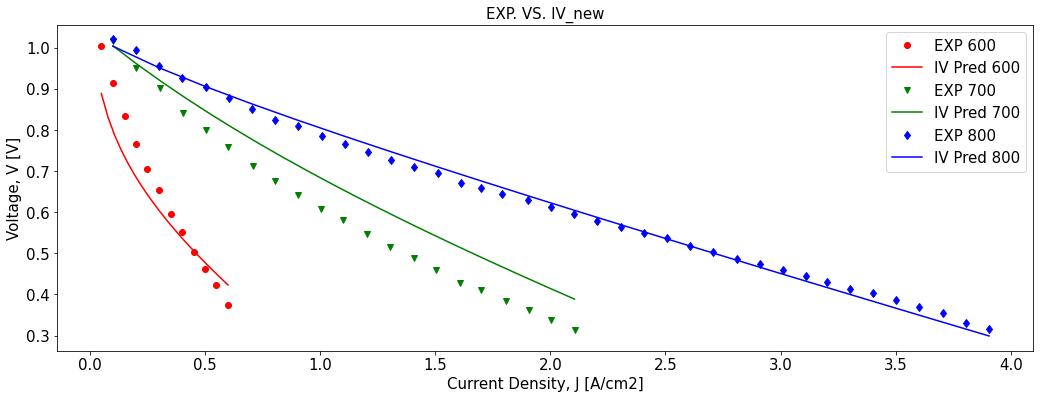

In [12]:
#comparison between Park-2020 experimental data (t8) and IV_new predicitons

#initilize and optimize
param_guess = (0.5,2, 1000, 0, 0, 0.28, 0.28)
bnds = ((0.2, 0.7), (0,None),(0,None),(None, 0), (0, None), (0.2, 2.0), (0.2, 2.0)) ## bounds changed

# BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
# DsurfH2th1=0.1, DsurfH2th2=4.51e-5,
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Tlist = [600, 700, 800]
th_e = 8
param_fixed = [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,th_e]

def objective_function_BP(param_guess, param_fixed):  
    filename = './ExperimentalData/BP2020/AllData_BP.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]
    [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,th_e] = param_fixed

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_model.IV_new_3_5(Toper[j]+273.15,Toper[j]+273.15,x[j],
                                                           pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                           param_guess[0],param_guess[1], param_guess[2],
                                                             param_guess[3], param_guess[4], 0.1, 4.51e-5,
                                                             True,param_guess[5],param_guess[6])
    rmse = mean_squared_error(y_exp, y_model, squared=False)
    return rmse

obj_guess = objective_function_BP(param_guess, param_fixed)
result = minimize(objective_function_BP, param_guess, args = (param_fixed), method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']

plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './ExperimentalData/BP2020/t8/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=20)   #Current density, unit [A/cm2]
    Vlist = np.zeros(20)
    
    # plot pred data
    for j in range(20):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_model.IV_new_3_5(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys, 
                                                         result.x[0], result.x[1],result.x[2],
                                                         result.x[3], result.x[4], 
                                                         0.1, 4.51e-5, True, result.x[5], result.x[6],  th_e)
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

# IV_new_4 : 2nd order Taylor Approximation - Explicit Function 

     fun: 0.04693757594916192
     jac: array([-1.53458590e-01,  9.40309837e-06, -6.98398799e-06,  1.21390447e-04,
        1.71288382e-04,  4.82217874e-04, -5.06774522e-05])
 message: 'Optimization terminated successfully'
    nfev: 65
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([ 6.00000000e-01,  5.63899995e+03,  7.96160000e+04, -8.11476134e-02,
        3.99214619e-01,  2.00000000e-01,  2.27425977e-01])


Text(0.5, 1.0, 'EXP. VS. IV_new')

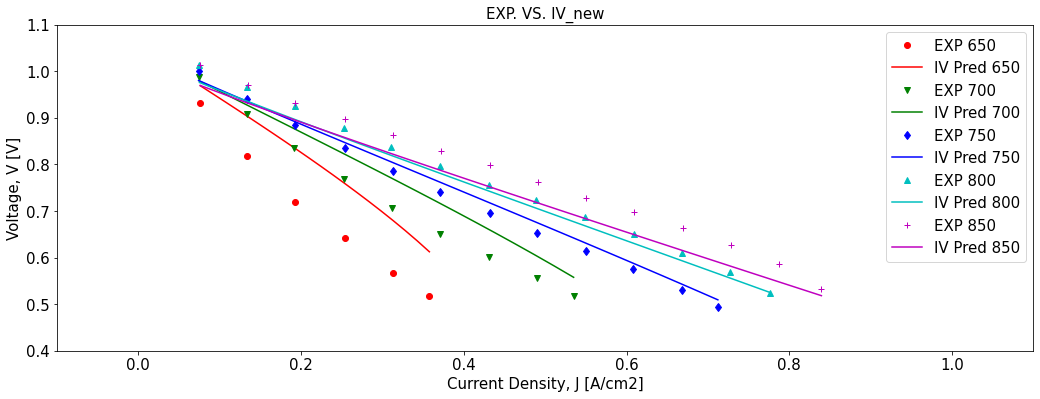

In [13]:
# comparison between JHM-2017 experimental data and IV_new predicitons

#initilize and optimize
param_guess = (0.52, 5639, 79616, 0.0, 0.0, 0.228, 0.228)

# BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
# DsurfH2th1=0.1, DsurfH2th2=4.51e-5,
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Tlist = [650, 700, 750, 800, 850]
th_e = 10
param_fixed = [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys]

def objective_function_JM(param_guess, param_fixed):  
    
    [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys] = param_fixed

    filename = './ExperimentalData/JM2017/AllData_JM.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_model.IV_new_4(Toper[j]+273.15,Toper[j]+273.15,x[j],
                                                           pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                           param_guess[0], param_guess[1], param_guess[2],
                                                           param_guess[3], param_guess[4], 0.1, 4.51e-5,
                                                             True,param_guess[5],param_guess[6])
    rmse = mean_squared_error(y_exp, y_model,squared=False)
    return rmse

obj_guess = objective_function_JM(param_guess, param_fixed)
bnds = ((0.2, 0.6), (0.0, None), (0.0, None), (None, 0.0), (0.0, None), (0.2, 2.0), (0.2, 2.0))
result = minimize(objective_function_JM, param_guess, args = (param_fixed), method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']
plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './ExperimentalData/JM2017/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=20)   #Current density, unit [A/cm2]
    Vlist = np.zeros(20)
    
    # plot pred data
    for j in range(20):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_model.IV_new_4(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                       result.x[0],result.x[1],result.x[2],
                                                       result.x[3], result.x[4], 0.1, 4.51e-5,
                                                       True,result.x[5],result.x[6])
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.xlim(-0.1, 1.1)
plt.ylim(0.4, 1.1)
# ymin, ymax = plt.ylim()
# plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

As shown here, the Vact approximation result is very sensitive to BV parameters. Hopefully SA can tell us which parameter is more sensitive over others to conduct dimention reduction.

     fun: 0.07995892418851105
     jac: array([-1.80484137e-01,  1.09048560e-05, -7.49994069e-06,  6.45658933e-04,
        1.14384107e-03,  3.06485035e-03, -1.14696100e-04])
 message: 'Optimization terminated successfully'
    nfev: 108
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([ 6.00000000e-01,  4.99999988e+03,  7.00000001e+04, -1.96831760e-01,
        3.56237271e-02,  2.00000000e-01,  2.29666245e-01])


Text(0.5, 1.0, 'EXP. VS. IV_new')

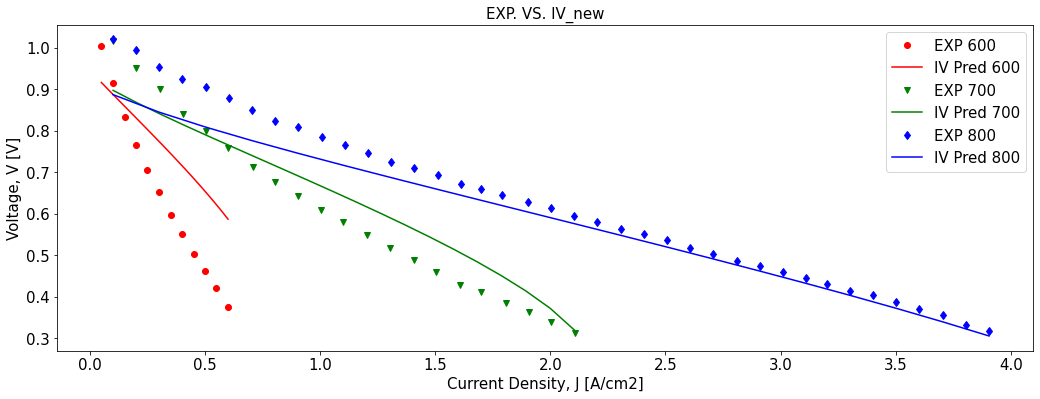

In [14]:
#comparison between Park-2020 experimental data (t8) and IV_new predicitons

#initilize and optimize
param_guess = (0.41, 5000, 70000, 0.0, 0.0, 0.228, 0.228)
bnds = ((0.3, 0.6), (0, None), (0, None), (None, 0), (0, None), (0.2, 2.0), (0.2, 2.0)) ## bounds changed

# BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
# DsurfH2th1=0.1, DsurfH2th2=4.51e-5,
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Tlist = [600, 700, 800]
th_e = 8
param_fixed = [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,th_e]

def objective_function_BP(param_guess, param_fixed):  
    filename = './ExperimentalData/BP2020/AllData_BP.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]
    [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,th_e] = param_fixed

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_model.IV_new_4(Toper[j]+273.15,Toper[j]+273.15,x[j],
                                                           pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                           param_guess[0],param_guess[1],param_guess[2],
                                                           param_guess[3], param_guess[4], 
                                                           0.1, 4.51e-5, True, param_guess[5], param_guess[6],  th_e)
    rmse = mean_squared_error(y_exp, y_model, squared=False)
    return rmse

obj_guess = objective_function_BP(param_guess, param_fixed)
result = minimize(objective_function_BP, param_guess, args = (param_fixed), method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']

plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './ExperimentalData/BP2020/t8/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=20)   #Current density, unit [A/cm2]
    Vlist = np.zeros(20)
    
    # plot pred data
    for j in range(20):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_model.IV_new_4(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys, 
                                                         result.x[0],result.x[1],result.x[2], 
                                                         result.x[3], result.x[4], 
                                                         0.1, 4.51e-5, True, result.x[5], result.x[6],  th_e)
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

The general problem with using 2nd order approximation for both the IV_new_4 and IV_new_5 is that the alpha bounds for both do not exceed 0.6. The alculation goes to NaN beyond that point.

# IV_new_5: 2nd order approximation + Tafel

     fun: 0.0469471166078816
     jac: array([-1.52528557e-01,  9.33324918e-06, -6.93183392e-06, -2.93593155e-03,
        1.37774926e-03, -9.82824713e-05, -3.48011963e-05])
 message: 'Optimization terminated successfully'
    nfev: 73
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([ 6.00000000e-01,  5.63899995e+03,  7.96160000e+04, -8.24174358e-02,
        4.05113768e-01,  2.32356931e-01,  2.79653913e-01])


Text(0.5, 1.0, 'EXP. VS. IV_new')

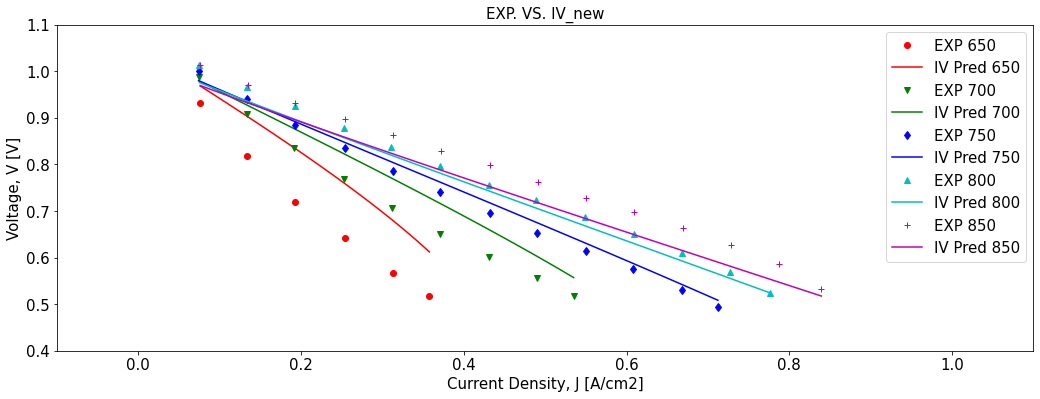

In [15]:
# comparison between JHM-2017 experimental data and IV_new predicitons

#initilize and optimize
param_guess = (0.43236, 5639, 79616, 0.0, 0.0, 0.28, 0.28) # won't let the upper bound to be greater than 0.6
#param_guess = (0.49, 4000, 100000, 0.0, 0.0, 0.228, 0.228)not working at all
# BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
# DsurfH2th1=0.1, DsurfH2th2=4.51e-5,
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Tlist = [650, 700, 750, 800, 850]
th_e = 10
param_fixed = [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys]

def objective_function_JM(param_guess, param_fixed):  
    
    [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys] = param_fixed

    filename = './ExperimentalData/JM2017/AllData_JM.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_model.IV_new_5(Toper[j]+273.15,Toper[j]+273.15,x[j],
                                                           pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                           param_guess[0], param_guess[1], param_guess[2],
                                                           param_guess[3], param_guess[4], 0.1, 4.51e-5,
                                                             True,param_guess[5],param_guess[6])
    rmse = mean_squared_error(y_exp, y_model, squared=False)
    return rmse

obj_guess = objective_function_JM(param_guess, param_fixed)
bnds = ((0.2, 0.6), (0.0, None), (0.0, None), (None, 0.0), (0.0, None), (0.2, 2.0), (0.2, 2.0))
result = minimize(objective_function_JM, param_guess, args = (param_fixed), method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']
plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './ExperimentalData/JM2017/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=20)   #Current density, unit [A/cm2]
    Vlist = np.zeros(20)
    
    # plot pred data
    for j in range(20):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_model.IV_new_5(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                       result.x[0],result.x[1],result.x[2],
                                                       result.x[3], result.x[4], 0.1, 4.51e-5,
                                                       True,result.x[5],result.x[6])
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.xlim(-0.1, 1.1)
plt.ylim(0.4, 1.1)
# ymin, ymax = plt.ylim()
# plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

     fun: 0.044435868281197805
     jac: array([-1.91438012e-04,  6.34416938e-06, -5.16744331e-06, -5.02807088e-05,
        3.89550813e-04,  5.32341329e-03, -9.10917297e-05])
 message: 'Optimization terminated successfully'
    nfev: 93
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([ 3.72932228e-01,  5.63899993e+03,  7.96160001e+04, -1.36362672e-01,
        8.76092882e-03,  2.00000000e-01,  2.29482770e-01])


Text(0.5, 1.0, 'EXP. VS. IV_new')

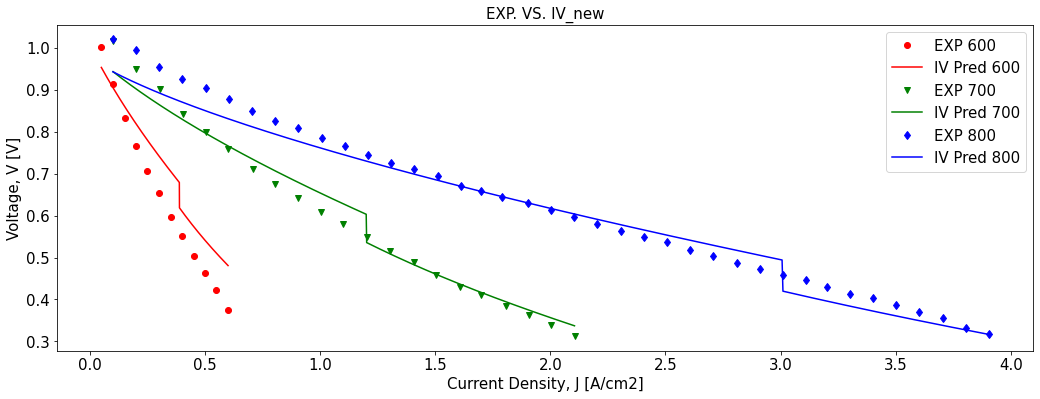

In [16]:
#comparison between Park-2020 experimental data (t8) and IV_new predicitons

#initilize and optimize
param_guess = (0.51, 5639, 79616, 0.0, 0.0, 0.228, 0.228)
bnds = ((0.2, 0.7), (0, None), (0, None), (None, 0), (0, None), (0.2, 2.0), (0.2, 2.0)) ## bounds changed

# BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
# DsurfH2th1=0.1, DsurfH2th2=4.51e-5,
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Tlist = [600, 700, 800]
th_e = 8
param_fixed = [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,th_e]

def objective_function_BP(param_guess, param_fixed):  
    filename = './ExperimentalData/BP2020/AllData_BP.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]
    [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,th_e] = param_fixed

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_model.IV_new_5(Toper[j]+273.15,Toper[j]+273.15,x[j],
                                                           pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                           param_guess[0],param_guess[1],param_guess[2],
                                                           param_guess[3], param_guess[4], 
                                                           0.1, 4.51e-5, True, param_guess[5], param_guess[6],  th_e)
    rmse = mean_squared_error(y_exp, y_model, squared=False)
    return rmse

obj_guess = objective_function_BP(param_guess, param_fixed)
result = minimize(objective_function_BP, param_guess, args = (param_fixed), method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']

plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './ExperimentalData/BP2020/t8/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=1000)   #Current density, unit [A/cm2]
    Vlist = np.zeros(1000)
    
    # plot pred data
    for j in range(1000):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_model.IV_new_5(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys, 
                                                         result.x[0],result.x[1],result.x[2], 
                                                         result.x[3], result.x[4], 
                                                         0.1, 4.51e-5, True, result.x[5], result.x[6],  th_e)
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

## My Takeaway:
Hyperbolic sine was the easiest function to use. It showed lesser sensitivity to the initial guess. 
Second order approximation may have shown similar accuracy as hyperbolic, the parameters were wayyyyy too sensitive to the initial values. 
2nd+Tafel: shown a great accuracy with less sensitivity but has shown discrepancy when switching from second to tafel. I tried changing the number of data points from 20 to 100, but increasing the data points did not minimize the discrepancy. 